In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import xarray as xr
import rioxarray
import scipy.io as sio
import datetime
import pandas as pd
from scipy.signal import argrelextrema, argrelmax, argrelmin
from shapely.geometry import Polygon
import geojson
import mat73
import ir_utils
import geopandas as gpd

In [2]:
# Import some packages for working with the SnowEx SQL database
from snowexsql.db import get_db # Import the connection function from the snowexsql library
from  snowexsql.data import SiteData # Import the table classes from our data module which is where our ORM classes are defined 
from datetime import date # Import some tools to build dates 
from snowexsql.conversions import query_to_geopandas # Import a useful function for plotting and saving queries! See https://snowexsql.readthedocs.io/en/latest/snowexsql.html#module-snowexsql.conversions

### Load IR and Visible (EO) image mosaics from Feb 8th flights.

In [3]:
files = [r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb08_mosaicked.mat',
         r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_EO_PLANE_2020Feb08_mosaicked.mat',
         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb10_mosaicked.mat',
         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked.mat',
         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb12_mosaicked.mat'
        ]

ds_eo = ir_utils.eo_mat2dataset(files[1])
#ds_eo['SRGB'] = ds_eo.SRGB.transpose('time', 'y', 'x','band')

ds_ir = ir_utils.ir_mat2dataset(files[0])
#ds_ir['STCtemp'] = ds_ir.STCtemp.transpose('time', 'y', 'x').rio.reproject('EPSG:26912')

In [4]:
# export vis image geotiffs
#ds_eo.SRGB.isel(time=8, band=0).plot()

#ds_eo.SRGB.isel(time=8).transpose('band', 'y', 'x').rio.to_raster('SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_2020-02-08T181915.tif')

#ds_eo.SRGB.isel(time=7).transpose('band', 'y', 'x').rio.to_raster('SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_2020-02-08T180739.tif')

### Get locations of ground points

Snowpit 2S10

In [5]:
# snowpit from the snowexsql database
# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [6]:
# Form the query to receive site_id='2S10' from the sites table
qry = session.query(SiteData).filter_by(site_id='2S10')

# Convert the record received into a geopandas dataframe
snow_pit_df = query_to_geopandas(qry, engine).to_crs(ds_ir.rio.crs)

# Preview the resulting geopandas dataframe
snow_pit_df

,site_name,date,time_created,time_updated,id,doi,date_accessed,latitude,longitude,northing,...,weather_description,precip,sky_cover,wind,ground_condition,ground_roughness,ground_vegetation,vegetation_height,tree_canopy,site_notes
0,Grand Mesa,2020-02-05,2022-06-30 22:28:52.494279+00:00,None,130,https://doi.org/10.5067/DUD2VZEVBJ7S,None,39.019474,-108.192316,4322689.0,...,"Sunny and cold, some blowing snow",None,Few (< 1/4 of sky),Moderate,Frozen,Rough,"Grass, Shrub","20, 30",No Trees,None


Mesa West met station

In [7]:
# Met stations that aren't in the snowexsql database
#convert met site data to a geodataframe for plotting with DEM basemap
met_sites = pd.read_csv(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\SnowEx\SnowEx Met Data\SnowEx2020_met_data\MesaMetSites.csv')
#met_sites['geometry'] = [Point(row['longitude'], row['latitude']) for row in met_sites]
met_sites_gdf = gpd.GeoDataFrame(met_sites, geometry=gpd.points_from_xy(met_sites.longitude, met_sites.latitude))
met_sites_gdf.crs = 4236

In [8]:
met_sites_gdf

,siteName,siteShortName,latitude,longitude,elev_m,start,end,geometry
0,LSOS,LSOS,39.05225,-108.09792,2974,10/9/16 18:20,5/17/17 15:40,POINT (-108.09792 39.05225)
1,Mesa East,ME,39.10358,-107.88383,2750,10/10/16 16:30,7/28/20 11:30,POINT (-107.88383 39.10358)
2,Mesa West,MW,39.03388,-108.21399,3033,10/9/16 21:00,7/8/20 17:00,POINT (-108.21399 39.03388)
3,Mesa Middle,MM,39.03954,-107.94174,3176,10/10/16 19:00,6/9/20 20:10,POINT (-107.94174 39.03954)
4,Skyway,GMSP,39.05084,-108.06144,3234,10/10/16 0:50,7/19/20 5:50,POINT (-108.06144 39.05084)


In [9]:
ds_ir.rio.crs

CRS.from_epsg(32613)

In [10]:
# Select the Mesa West site, and reproject to UTM
mesa_west_df = met_sites_gdf[met_sites_gdf.siteName == 'Mesa West'].to_crs(ds_ir.rio.crs)

# correct the point
mesa_west_df['geometry'] = gpd.points_from_xy([221797.741], [4325448.904], crs=ds_ir.rio.crs)

# Preview the resulting geopandas dataframe
mesa_west_df

,siteName,siteShortName,latitude,longitude,elev_m,start,end,geometry
2,Mesa West,MW,39.03388,-108.21399,3033,10/9/16 21:00,7/8/20 17:00,POINT (221797.741 4325448.904)


---

In [11]:
def get_hist_trough(data):
    
    '''Function for finding the local minima (troughs) between peaks in a histogram.'''
    
    # first, find peaks
    x_peaks, y_peaks, _, _ = get_hist_peaks(data)
    
    # only look at data between the two peaks
    data = data[(data > x_peaks[0]) & (data < x_peaks[1])]
    
    # data histogram
    n_histogram, _ = np.histogram(data, bins=100, density=True)
    
    # make our own data bins of length n
    x = np.linspace(np.min(data), np.max(data), num=len(n_histogram))
    
    # find minimum n_troughs
    if len(np.sort(n_histogram[argrelmin(n_histogram, order=1)]))>1:
        trough_y_values = np.sort(n_histogram[argrelmin(n_histogram, order=1)])[0]
    else:
        trough_y_values = np.sort(n_histogram[argrelmin(n_histogram, order=1)])
    # find corresponding x values to the n_troughs
    trough_x_values = x[np.where(np.isin(n_histogram,trough_y_values))]
    
    # demo plot
    #plt.bar(x, n_histogram)
    #plt.plot(trough_x_values, trough_y_values,'or')
    
    x_hist = x
    y_hist = n_histogram
    
    return trough_x_values, trough_y_values, x_hist, y_hist

In [12]:
def get_hist_peaks(data,n_peaks=2):
    
    '''Function for finding the local maxima (peaks) in a histogram.'''
    
    # remove nans from data
    data = data[~np.isnan(data)]
    
    # data histogram
    n_histogram, _ = np.histogram(data, bins=100, density=True)
    
    # make our own data bins of length n
    x = np.linspace(np.min(data), np.max(data), num=len(n_histogram))
    
    # find maximum n_peaks
    peak_y_values = np.sort(n_histogram[argrelmax(n_histogram, order=2)])[-n_peaks:][::-1]
    # find corresponding x values to the n_peaks
    peak_x_values = x[np.where(np.isin(n_histogram,peak_y_values))]
    
    # demo plot
    #plt.bar(x, n_histogram)
    #plt.plot(peak_x_values, peak_y_values,'or')
    
    x_hist = x
    y_hist = n_histogram
    
    return peak_x_values, peak_y_values, x_hist, y_hist

---

# Load ASTER

In [13]:
def tir_dn2rad(DN, band):
    '''Convert AST_L1T Digital Number values to At-Sensor Radiance for the TIR bands (bands 10-14).'''
    ucc = [6.822e-3, 6.780e-3, 6.590e-3, 5.693e-3, 5.225e-3]
    rad = (DN-1.) * ucc[band-10]
    return rad

def tir_rad2tb(rad, band):
    '''Convert AST_L1T At-Sensor Radiance to Brightness Temperature [K] for the TIR bands (bands 10-14).'''
    k1 = [3047.47, 2480.93, 1930.80, 865.65, 649.60]
    k2 = [1736.18, 1666.21, 1584.72,1349.82, 1274.49]
    tb = k2[band-10] /  np.log((k1[band-10]/rad) + 1)
    return tb

In [14]:
# reproject to local UTM coordinates
#aster_l1t_filepath = r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\ASTER\ASTER_L1T_2020_GrandMesa_SnowEx\output\AST_L1T_00302082020180748_20200209065849_17218_ImageData14.tif"
#dst_crs = 'EPSG:4326'
#new_filepath = aster_utils.reproject_aster_l1t(aster_l1t_filepath, dst_crs = 'EPSG:32613')
#print(new_filepath)

new_filepath = r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\ASTER\ASTER_L1T_2020_GrandMesa_SnowEx\output\AST_L1T_00302082020180748_20200209065849_17218_ImageData14_EPSG_32613.tif"

In [15]:
# Open ASTER image
aster_b14_DN = xr.open_dataset(new_filepath, engine="rasterio")
aster_b14_DN.rio.write_crs("epsg:32613", inplace=True)
aster_b14_DN = aster_b14_DN.squeeze()

#Convert DN to radiance, then radiance to brightness temperature
# ASTER band number for conversion functions
band_number = 14

# Convert DN to Radiance
aster_b14_rad = tir_dn2rad(aster_b14_DN, band_number)

# Convert Radiance to Brightness Temperature [K]
aster_b14_tb = tir_rad2tb(aster_b14_rad, band_number)

---
### Load in situ met data

In [16]:
#df = pd.read_csv(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\SnowEx\SnowEx Met Data\SnowEx2020_met_data\MW-V7_clean.csv')

In [17]:
#datestrings = [str(df['Year'][i]) + '-' + str(df['DOY'][i]) +'T' + str(df['Hour'][i]) +':' + str(df['Minute'][i]) +':00' for i in range(len(df))]
#df['datetime_UTC'] = pd.to_datetime(datestrings, format='%Y-%jT%H:%M:%S') + datetime.timedelta(hours=5)
##
#df.set_index('datetime_UTC', inplace=True)
## select Feb 8th 2020
#df = df.where((df.Year==2020) & (df.Month==2) & (df.DOY==39))
#df.head()
#
##df = pd.read_csv('data/example_GOES_4band_tempSep_GrandMesa_Feb82020.csv')
##datestrings = [str(df['year'][i]) + '-' + str(df['doy'][i]) +'T' + str(df['hour'][i]) +':' + str(df['minute'][i]) +':00' for i in range(len(df))]
##df['datetime_UTC'] = pd.to_datetime(datestrings, format='%Y-%jT%H:%M:%S') + datetime.timedelta(hours=6)
##df.set_index('datetime_UTC', inplace=True)
##df.head()

---
---
### Load in situ data from snow pit 2s10

In [18]:
#def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
#                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
#    # From: https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas
#    years = np.asarray(years) - 1970
#    months = np.asarray(months) - 1
#    days = np.asarray(days) - 1
#    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
#             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
#    vals = (years, months, days, weeks, hours, minutes, seconds,
#            milliseconds, microseconds, nanoseconds)
#    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
#               if v is not None)

In [19]:
## Set column headers:
#headers_gm1 = ['table', 'year', 'doy', 'time',
#               'rad_avg', 'rad_max', 'rad_min', 'rad_std',
#               'sb_avg', 'sb_max', 'sb_min', 'sb_std',
#               'temp1_avg', 'temp1_max', 'temp1_min', 'temp1_std',
#               'temp2_avg', 'temp2_max', 'temp2_min', 'temp2_std',
#               'temp3_avg', 'temp3_max', 'temp3_min', 'temp3_std',
#               'temp4_avg', 'temp4_max', 'temp4_min', 'temp4_std',
#               'temp5_avg', 'temp5_max', 'temp5_min', 'temp5_std',
#               'batt','b',]
#
## Open ground data from GM1 site:
#gm1 = pd.read_csv('data/CR10X_GM1_final_storage_1.dat',
#                 header = None, names = headers_gm1)
#
## Pad zeros to time strings
#gm1['time_str'] = [('0' * (4 - len(str(gm1.time[i])))) + str(gm1.time[i]) for i in range(gm1.shape[0])]
#
#for i in range(gm1.shape[0]):
#    if gm1.time_str[i] == '2400':
#        gm1.time_str[i] = '0000'
#        gm1.doy[i] = gm1.doy[i] + 1
#        
## Convert year and day of year to pandas datetime index and convert from UTC-7 to UTC:
#gm1['date'] = compose_date(gm1['year'], days=gm1['doy'])
#gm1.index = [pd.to_datetime(str(gm1.date[i])[:-9] + 'T' + str(gm1.time_str[i])) + datetime.timedelta(hours=7) for i in range(gm1.shape[0])] 
#
## Get table 102 entires, battery info
#gm1_102 = gm1[gm1.table == 102]
#
## Remove entries that are part of "Table 102"
#gm1 = gm1[gm1.table != 102]
#
## Remove dates before observation periods (Feb 5th for GM1)
#gm1 = gm1[gm1.index >= pd.datetime(2020,2,5,11,0)]
#
#gm1.head()

---
## Load merged and cleaned data

In [20]:
df_merged = pd.read_csv(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\Mountain GOES Paper\Paper 2 - satellite vs ground\GOES-16_ABI_data\merged_datasets.csv')
df_merged.set_index(pd.to_datetime(df_merged.datetime), inplace=True)

In [21]:
df_merged

,datetime,pxA_t,pxA_x_2km,pxA_y_2km,pxA_x_1km_W,pxA_x_1km_E,pxA_y_1km_N,pxA_y_1km_S,pxA_b1_rad_1km_NW,pxA_b1_rad_1km_NE,...,pxE_b13_rad_2km,pxE_b13_tb_2km,pxE_b14_rad_2km,pxE_b14_tb_2km,pxE_b15_rad_2km,pxE_b15_tb_2km,pxE_b16_rad_2km,pxE_b16_tb_2km,rad_avg,AirTC_20ft_Avg
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-07 00:01:00,2020-02-07 00:01:00,2020-02-07 00:01:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,72.328224,88.570351,...,34.801651,242.573807,41.784950,241.685333,49.698959,240.644302,53.212227,237.141129,265.9963,265.477000
2020-02-07 00:06:00,2020-02-07 00:06:00,2020-02-07 00:06:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,63.395058,74.764542,...,34.893108,242.684448,41.883934,241.792435,49.857281,240.800369,53.036167,236.971130,265.9010,265.504167
2020-02-07 00:11:00,2020-02-07 00:11:00,2020-02-07 00:11:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,49.589249,55.273994,...,34.984566,242.794876,41.933426,241.845932,49.751732,240.696350,52.860111,236.800797,265.8292,265.531333
2020-02-07 00:16:00,2020-02-07 00:16:00,2020-02-07 00:16:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,35.783440,43.904503,...,35.761955,243.725967,43.319206,243.327560,51.493279,242.395920,54.444637,238.322113,265.8386,265.558500
2020-02-07 00:21:00,2020-02-07 00:21:00,2020-02-07 00:21:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,28.474478,27.662374,...,34.390087,242.073639,41.784950,241.685333,49.857281,240.800369,53.212227,237.141129,265.8273,265.585667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-12 23:36:00,2020-02-12 23:36:00,2020-02-12 23:36:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,59.334526,57.710312,...,48.886154,257.778320,58.364838,257.794830,68.064346,257.096497,65.888443,248.626770,263.4899,263.021167
2020-02-12 23:41:00,2020-02-12 23:41:00,2020-02-12 23:41:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,55.273994,55.273994,...,48.748970,257.644867,58.067886,257.533112,67.747704,256.836517,66.064499,248.777069,263.4899,262.976333
2020-02-12 23:46:00,2020-02-12 23:46:00,2020-02-12 23:46:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,59.334526,57.710312,...,48.383137,257.287842,57.671947,257.182831,67.431061,256.575836,65.712387,248.476303,263.4899,262.931500


---
---

# Plotting

In [22]:
target = 'snow pit'
#target = 'mesa west'
ds = ds_ir

# Select a time window from the timeseries data around each airborne or satellite observation
plus_minus_minutes = 10 # e.g. +/- 5 minutes for a 10 minute time window

mean_AirTC_10ft_Avg_C = []
mean_AirTC_20ft_Avg_C = []
mean_IRtarget_nadir1_C_Avg = []
mean_IRtarget_30degN_C_Avg = []
gm1_2s10_IR_45deg_C = []

for i, t in enumerate(ds.time.values):
    window_start_time = pd.to_datetime(t) - datetime.timedelta(minutes=plus_minus_minutes)
    window_end_time = pd.to_datetime(t) + datetime.timedelta(minutes=plus_minus_minutes)
    #df_sliced = df[(df.index>window_start_time) & (df.index<window_end_time)]
    #gm1_sliced = gm1[(gm1.index>window_start_time) & (gm1.index<window_end_time)]
    df_merged_sliced = df_merged[(df_merged.index>window_start_time) & (df_merged.index<window_end_time)]

    #mean_AirTC_10ft_Avg_C.append(df_sliced.AirTC_10ft_Avg_C.mean())
    #mean_AirTC_20ft_Avg_C.append(df_sliced.AirTC_20ft_Avg_C.mean())
    mean_AirTC_20ft_Avg_C.append(df_merged_sliced.AirTC_20ft_Avg.mean()-273.15)
    #mean_IRtarget_nadir1_C_Avg.append(df_sliced.IRtarget_nadir1_C_Avg.mean())
    #mean_IRtarget_30degN_C_Avg.append(df_sliced.IRtarget_30degN_C_Avg.mean())
    #gm1_2s10_IR_45deg_C.append(gm1_sliced.rad_avg.mean())
    gm1_2s10_IR_45deg_C.append(df_merged_sliced.rad_avg.mean()-273.15)

C:\Users\steve\AppData\Local\Temp\ipykernel_3416\2265945876.py:70: RuntimeWarning: Mean of empty slice
  mean_difference = np.nanmean(np.nanmean(point_temps, axis=(1,2)) - np.array(gm1_2s10_IR_45deg_C))
C:\Users\steve\AppData\Local\Temp\ipykernel_3416\2265945876.py:71: RuntimeWarning: Mean of empty slice
  ax.plot(gm1_2s10_IR_45deg_C, np.nanmean(point_temps, axis=(1,2)), '.b')
C:\Users\steve\AppData\Local\Temp\ipykernel_3416\2265945876.py:70: RuntimeWarning: Mean of empty slice
  mean_difference = np.nanmean(np.nanmean(point_temps, axis=(1,2)) - np.array(gm1_2s10_IR_45deg_C))
C:\Users\steve\AppData\Local\Temp\ipykernel_3416\2265945876.py:71: RuntimeWarning: Mean of empty slice
  ax.plot(gm1_2s10_IR_45deg_C, np.nanmean(point_temps, axis=(1,2)), '.b')
C:\Users\steve\AppData\Local\Temp\ipykernel_3416\2265945876.py:70: RuntimeWarning: Mean of empty slice
  mean_difference = np.nanmean(np.nanmean(point_temps, axis=(1,2)) - np.array(gm1_2s10_IR_45deg_C))
C:\Users\steve\AppData\Local\Temp\ipy

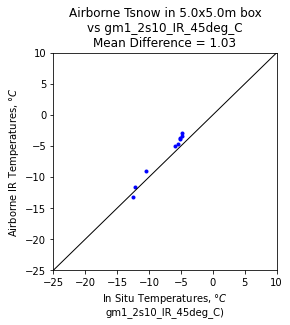

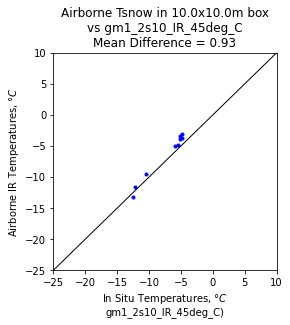

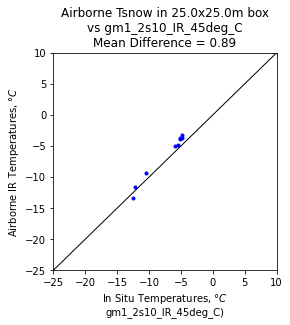

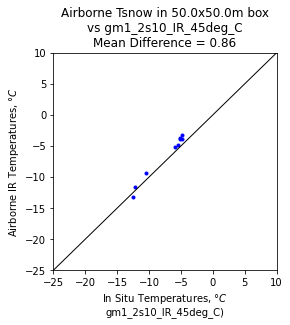

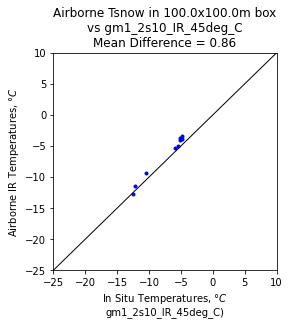

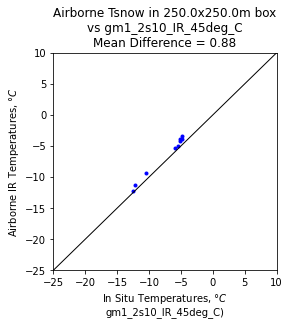

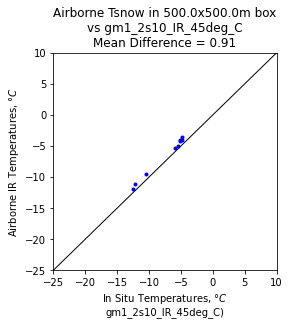

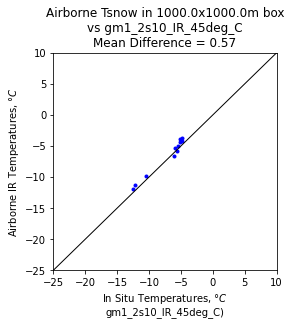

In [25]:
mean_differences = []
point_temps_list = []


aster_time = np.datetime64('2020-02-08T18:07:48')
aster_window_start_time = pd.to_datetime(aster_time) - datetime.timedelta(minutes=plus_minus_minutes)
aster_window_end_time = pd.to_datetime(aster_time) + datetime.timedelta(minutes=plus_minus_minutes)
gm1_aster_time = df_merged[(df_merged.index>aster_window_start_time) & (df_merged.index<aster_window_end_time)]

aster_point_temps = []

# set the spatial extent for looking at the exact "point"
#n_pixels_list = [1, 2, 5, 10, 25, 50, 100, 150, 200, 250]
point_window_list = [5/2, 10/2, 25/2, 50/2, 100/2, 250/2, 500/2, 1000/2]

for point_window in point_window_list:
    #point_window = n_pixels*2.5 # must be >= 2.5 meters in order to capture at least one pixel
    x = point_window
    if target == 'mesa west':
        # mesa west tree stand area
        utm_xmin, utm_xmax = mesa_west_df.geometry.x.values[0]-x, mesa_west_df.geometry.x.values[0]+x #221800-x, 221800+x
        utm_ymin, utm_ymax = mesa_west_df.geometry.y.values[0]-x, mesa_west_df.geometry.y.values[0]+x #4325500-x, 4325500+x
    if target == 'snow pit':
        # snow pit 2s10 area
        utm_xmin, utm_xmax = snow_pit_df.geometry.x.values[0]-x, snow_pit_df.geometry.x.values[0]+x #221800-x, 221800+x
        utm_ymin, utm_ymax = snow_pit_df.geometry.y.values[0]-x, snow_pit_df.geometry.y.values[0]+x

    
    
    
    point_temps = []
    for time_index, time_step in enumerate(ds.time):
            # get temperature right at our ground point
            if target == 'mesa west':
                # mesa west
                point_temp_C = ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values
            if target == 'snow pit':
                # snow pit
                point_temp_C = ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values             
                
            point_temps.append(point_temp_C)
            
                     
            
    point_temps = np.array(point_temps)
    point_temps_list.append(point_temps)
    point_temps_removed_nans = point_temps[~np.isnan(point_temps)]
    point_temps_half_range = np.max(point_temps_removed_nans) - np.min(point_temps_removed_nans)

    
    # ASTER
    geometry = f'''{{"type": "Polygon", "coordinates": [[[{utm_xmin}, {utm_ymax}],[{utm_xmin}, {utm_ymin}],[{utm_xmax}, {utm_ymin}],[{utm_xmax}, {utm_ymax}],[{utm_xmin}, {utm_ymax}]]]}}'''
    cropping_geometries = [geojson.loads(geometry)]
    try:
        shapefile_tb = aster_b14_tb.rio.clip(geometries=cropping_geometries, crs=32613)
        aster_point_temps.append(shapefile_tb.band_data.values.mean())
    except:
        aster_point_temps.append(np.nan)
    
    fig, ax = plt.subplots(figsize=(4,4))
    
    if target == 'mesa west':
        mean_difference = np.nanmean(np.nanmean(point_temps, axis=(1,2)) - np.array(mean_AirTC_20ft_Avg_C))
        ax.plot(mean_AirTC_20ft_Avg_C, np.nanmean(point_temps, axis=(1,2)), '.b')
        ax.set_xlabel('In Situ Temperatures, $\degree C$\nAirTC_20ft_Avg_C)')
        ax.set_ylabel('Airborne IR Temperatures, $\degree C$')
        ax.set_title(f'Airborne Tsnow in {point_window*2}x{point_window*2}m box\nvs AirTC_20ft_Avg_C\nMean Difference = {np.round(mean_difference,2)}')

    if target == 'snow pit':
        mean_difference = np.nanmean(np.nanmean(point_temps, axis=(1,2)) - np.array(gm1_2s10_IR_45deg_C))
        ax.plot(gm1_2s10_IR_45deg_C, np.nanmean(point_temps, axis=(1,2)), '.b')
        ax.set_xlabel('In Situ Temperatures, $\degree C$\ngm1_2s10_IR_45deg_C)')
        ax.set_ylabel('Airborne IR Temperatures, $\degree C$')
        ax.set_title(f'Airborne Tsnow in {point_window*2}x{point_window*2}m box\nvs gm1_2s10_IR_45deg_C\nMean Difference = {np.round(mean_difference,2)}')

    
    ax.plot([-25,25],[-25,25],linestyle='-', linewidth=1,color='k')
    ax.set_ylim((-25,10))
    ax.set_xlim((-25,10))
    
    mean_differences.append(mean_difference)
    
    
aster_mean_differences = np.array(aster_point_temps) - np.ones_like(np.array(aster_point_temps))*gm1_aster_time.rad_avg.mean()



[1.0318583046807122, 0.9345309663560594, 0.8928532264709411, 0.8646640706804002, 0.8581463160196878, 0.8761698334164029, 0.9059782487233419, 0.5714804087205297]
[       nan        nan        nan        nan 0.03293711 0.11982065
 0.30112559 0.26499277]


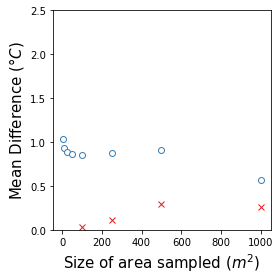

In [42]:
fig, ax = plt.subplots(figsize=(4,4),tight_layout=True)
ax.plot(np.array(point_window_list)*2, mean_differences, 'o', markerfacecolor='w', markeredgecolor='#377EB8')
ax.plot(np.array(point_window_list)*2, aster_mean_differences, 'x', c='#E41A1C')
ax.set_ylabel('Mean Difference ($\degree C$)', fontsize=15)
ax.set_xlabel('Size of area sampled ($m^2$)', fontsize=15)
ax.set_ylim(0,2.5)
print(mean_differences)
print(aster_mean_differences)
plt.savefig('sample_area_test_feb8.svg')

Text(0.5, 0, 'Temperature [$\\degree C$]')

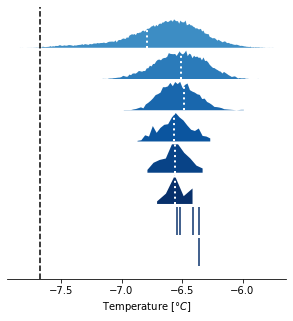

In [24]:
N = len(point_temps_list)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(1,0.5,N)))

fig, ax_hist = plt.subplots(figsize=(5,5))
for n, data in enumerate(point_temps_list):
    data = np.nanmean(data,axis=0).ravel()
    # plot histograms
    y_histogram, x_histogram = np.histogram(data, bins=int(np.sqrt(len(data))), density=True)
    x_histogram = x_histogram[:-1]
    if len(y_histogram) < 5:
        ax_hist.vlines(data, ymin=(n*1.1)+np.zeros_like(data),  ymax=(n*1.1)+np.ones_like(data))
    else:
        ax_hist.fill_between(x_histogram, y1=(n*1.1), y2=(n*1.1)+(y_histogram/(np.max(y_histogram))),zorder=-999)
        max_y = np.max((n*1.1)+(y_histogram/(np.max(y_histogram))))
        ax_hist.vlines(np.mean(x_histogram), ymin=(n*1.1), ymax=max_y, color='w', linestyle=':', lw=2, zorder=999) 
          
ax_hist.axvline(np.array(gm1_2s10_IR_45deg_C).mean(), 0, max_y, c='k', linestyle='--')  
#ax_hist.set_xlim(-17, -11)
#ax_hist.set_ylim(0,1)
ax_hist.set_ylabel('')
ax_hist.set(yticklabels=[])
ax_hist.get_yaxis().set_ticks([])
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['bottom'].set_visible(True)
ax_hist.spines['left'].set_visible(False)
ax_hist.set_xlabel('Temperature [$\degree C$]')

Tsnow_airborneIR_peak = [-11.78263888 -11.18907229  -9.85472347  -5.31988899  -5.11970539
  -4.20841347  -4.4518001   -4.03691637  -3.49093009]
Tsnow_airborneIR_median = [-11.922262  -11.214209   -9.850531   -5.3716645  -5.058539   -3.9528565
  -4.3870606  -4.112021   -3.6525178]
Tsnow_airborneIR_mean = [-11.928307  -11.198864   -9.821888   -5.3946266  -5.0548677  -3.8599565
  -4.4009776  -4.225947   -3.7521539]
Tsnow_airborneIR_min = [-14.480505  -13.312811  -12.422674   -7.1210694  -6.6163087  -6.1045594
  -5.83338    -6.8585877  -5.5779786]
Tsnow_airborneIR_max = [-8.797766  -8.534399  -7.0135865 -3.3270936 -2.6118836 -1.2912658
 -1.9254822 -1.8702759 -1.6045593]
Tsnow_airborneIR_std = [0.6933328  0.54863304 0.6494913  0.42483842 0.40609398 0.6746121
 0.32468754 0.51991045 0.5354994 ]


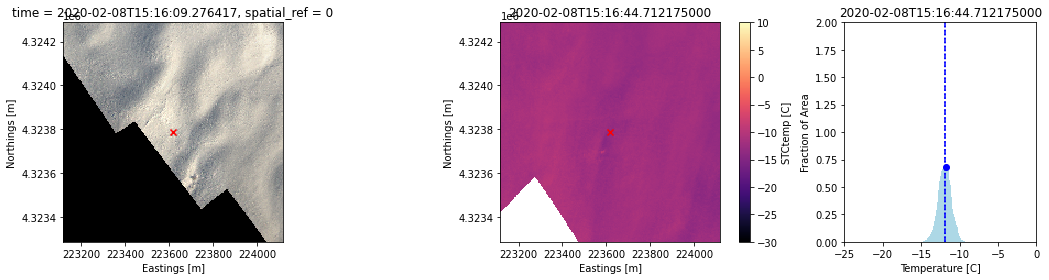

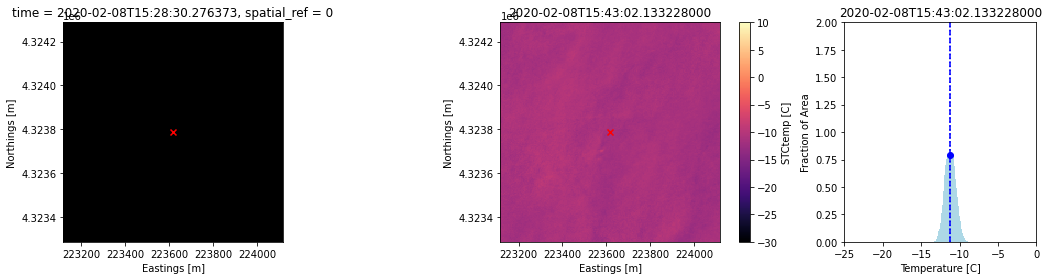

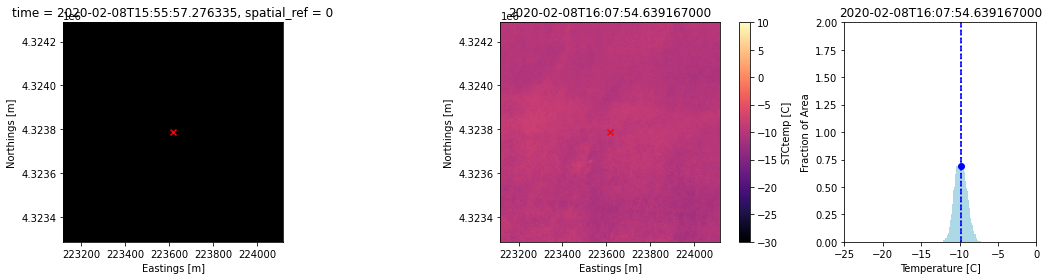

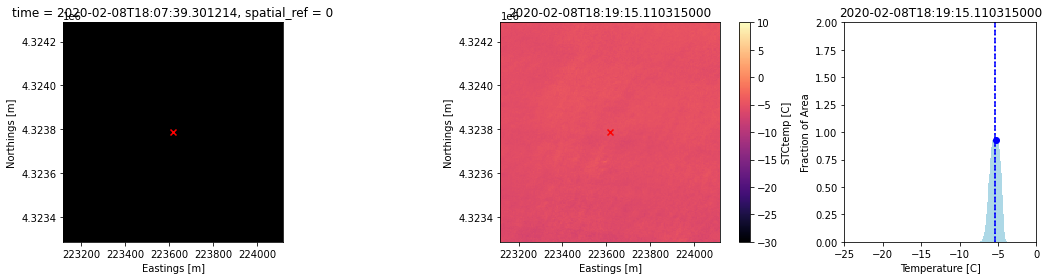

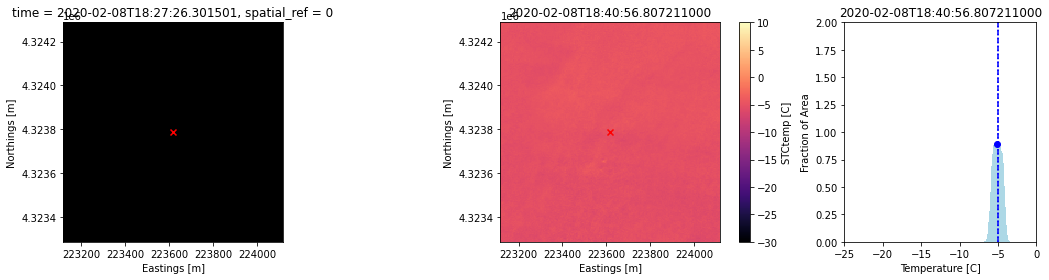

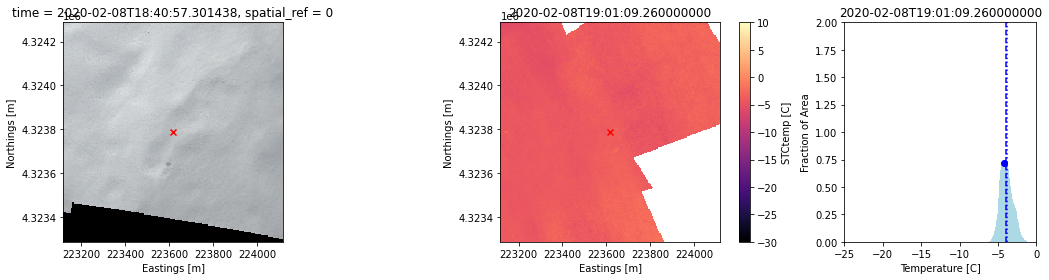

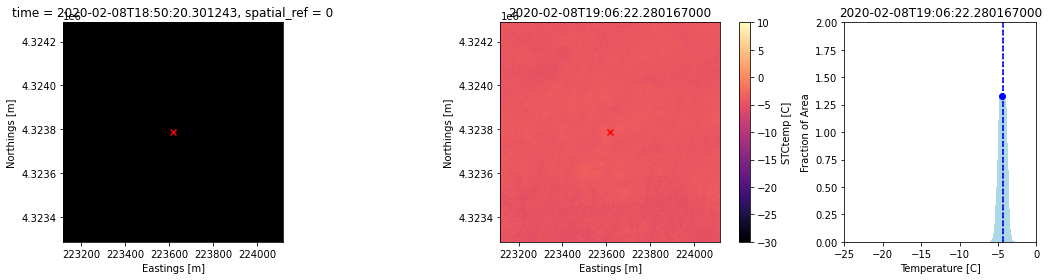

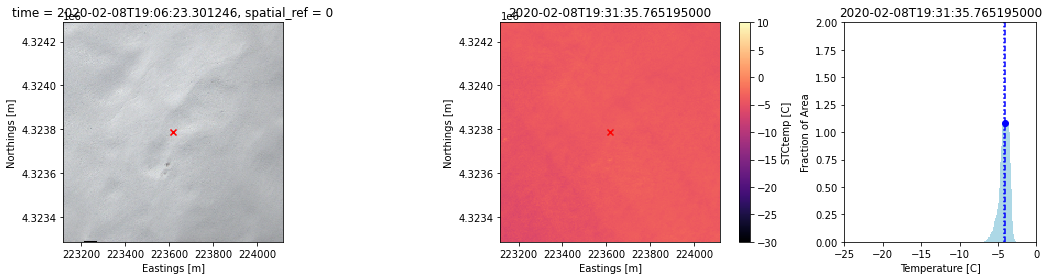

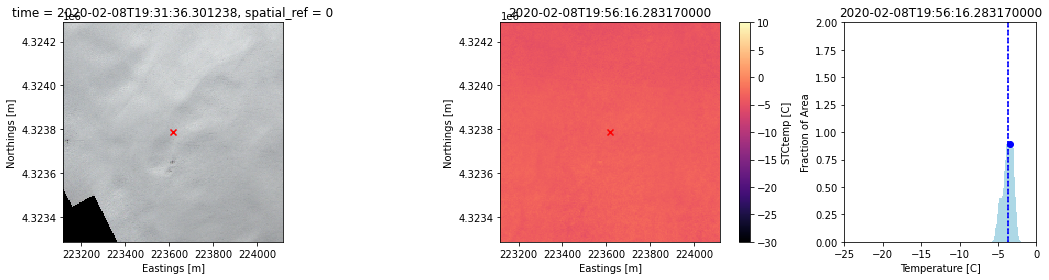

In [49]:
target = 'snow pit'
# Set the spatial extent for the area to look at
x=500 # meters, window will be a square 2x along each side

if target == 'mesa west':
    # mesa west tree stand area
    utm_xmin, utm_xmax = mesa_west_df.geometry.x.values[0]-x, mesa_west_df.geometry.x.values[0]+x #221800-x, 221800+x
    utm_ymin, utm_ymax = mesa_west_df.geometry.y.values[0]-x, mesa_west_df.geometry.y.values[0]+x #4325500-x, 4325500+x
if target == 'snow pit':
    # snow pit 2s10 area
    utm_xmin, utm_xmax = snow_pit_df.geometry.x.values[0]-x, snow_pit_df.geometry.x.values[0]+x #221800-x, 221800+x
    utm_ymin, utm_ymax = snow_pit_df.geometry.y.values[0]-x, snow_pit_df.geometry.y.values[0]+x


    
times = []
Tsnow_airborneIR_peak = []
Ttree_airborneIR_peak = []
Tsnow_airborneIR_median = []
Ttree_airborneIR_median = []
Tsnow_airborneIR_mean = []
Ttree_airborneIR_mean = []
Tsnow_airborneIR_min = []
Ttree_airborneIR_min = []
Tsnow_airborneIR_max = []
Ttree_airborneIR_max = []
Tsnow_airborneIR_std = []
Ttree_airborneIR_std = []

for time_index, time_step in enumerate(ds.time):
    nan_pixels = np.sum(np.isnan(ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values))
    if nan_pixels < 10000:
        fig, [ax_vis, ax_img, ax_hist] = plt.subplots(nrows=1,ncols=3,figsize=(15,4), tight_layout=True,
                                              gridspec_kw={'width_ratios': [2,2, 1]})
        
      
        # plot visible image
        ds_eo.SRGB.isel(time=time_index).sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax)).plot.imshow(ax=ax_vis)
        ax_vis.set_aspect('equal', 'box')
        ax_vis.set_ylabel('Northings [m]')
        ax_vis.set_xlabel('Eastings [m]')
        
        # plot ir image
        ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).plot.imshow(cmap='magma', vmin=-30, vmax=10, ax=ax_img)
        ax_img.set_aspect('equal', 'box')
        ax_img.set_ylabel('Northings [m]')
        ax_img.set_xlabel('Eastings [m]')
        
        ## plot ground points
        for this_ax in [ax_vis, ax_img]:
            if target == 'mesa west':
                mesa_west_df.plot(ax=this_ax, color='r', marker='x', zorder=999)
            if target == 'snow pit':
                snow_pit_df.plot(ax=this_ax, color='r', marker='x', zorder=999)
        
        # plot histograms
        data = ds.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values
        x_peaks, y_peaks, x_hist, y_hist = get_hist_peaks(data, n_peaks=1)
        x_trough, _, _, _ = get_hist_trough(data)
        if len(x_peaks) == 1: # add some placeholder data if we only are looking at n_peaks=1
            x_peaks = np.append(x_peaks, -9999)
            y_peaks = np.append(y_peaks, -9999)
            x_trough = [9999]
        x_hist_snow = x_hist[x_hist < x_trough[0]]
        y_hist_snow = y_hist[x_hist < x_trough[0]]
        x_hist_tree = x_hist[x_hist >= x_trough[0]]
        y_hist_tree = y_hist[x_hist >= x_trough[0]]
        ax_hist.bar(x_hist_snow, y_hist_snow, color='lightblue')
        ax_hist.axvline(np.median(data[data < x_trough[0]]),color='b',linestyle='--')
        ax_hist.axvline(np.mean(data[data < x_trough[0]]),color='b',linestyle=':')
        if target == 'mesa west':
            ax_hist.bar(x_hist_tree, y_hist_tree, color='lightgreen')
            ax_hist.axvline(np.median(data[data >= x_trough[0]]),color='g',linestyle='--')
            ax_hist.axvline(np.mean(data[data >= x_trough[0]]),color='g',linestyle=':')
        ax_hist.plot(x_peaks[0], y_peaks[0],'ob')
        ax_hist.plot(x_peaks[1], y_peaks[1],'^g')
        ax_hist.set_xlim(-25, 0)
        ax_hist.set_ylim(0,2)
        ax_hist.set_ylabel('Fraction of Area')
        ax_hist.set_xlabel('Temperature [C]')
        ax_img.set_title(time_step.values)
        ax_hist.set_title(time_step.values)
        # append values to lists
        times.append(time_step.values)
        Tsnow_airborneIR_peak.append(x_peaks[0])
        Tsnow_airborneIR_median.append(np.median(data[data < x_trough[0]]))
        Tsnow_airborneIR_mean.append(np.mean(data[data < x_trough[0]]))
        Tsnow_airborneIR_min.append(np.min(data[data < x_trough[0]]))
        Tsnow_airborneIR_max.append(np.max(data[data < x_trough[0]]))
        Tsnow_airborneIR_std.append(np.std(data[data < x_trough[0]])) 
        if target == 'mesa west':
            Ttree_airborneIR_peak.append(x_peaks[1])
            Ttree_airborneIR_median.append(np.median(data[data >= x_trough[0]]))
            Ttree_airborneIR_mean.append(np.mean(data[data >= x_trough[0]]))
            Ttree_airborneIR_min.append(np.min(data[data >= x_trough[0]]))
            Ttree_airborneIR_max.append(np.max(data[data >= x_trough[0]]))
            Ttree_airborneIR_std.append(np.std(data[data >= x_trough[0]]))
        
times = np.array(times)
Tsnow_airborneIR_peak = np.array(Tsnow_airborneIR_peak)
Tsnow_airborneIR_median = np.array(Tsnow_airborneIR_median)
Tsnow_airborneIR_mean = np.array(Tsnow_airborneIR_mean)
Tsnow_airborneIR_min = np.array(Tsnow_airborneIR_min)
Tsnow_airborneIR_max = np.array(Tsnow_airborneIR_max)
Tsnow_airborneIR_std = np.array(Tsnow_airborneIR_std)
print(f'Tsnow_airborneIR_peak = {Tsnow_airborneIR_peak}')
print(f'Tsnow_airborneIR_median = {Tsnow_airborneIR_median}')
print(f'Tsnow_airborneIR_mean = {Tsnow_airborneIR_mean}')
print(f'Tsnow_airborneIR_min = {Tsnow_airborneIR_min}')
print(f'Tsnow_airborneIR_max = {Tsnow_airborneIR_max}')
print(f'Tsnow_airborneIR_std = {Tsnow_airborneIR_std }')
if target == 'mesa west':
    Ttree_airborneIR_peak = np.array(Ttree_airborneIR_peak)
    Ttree_airborneIR_median = np.array(Ttree_airborneIR_median)
    Ttree_airborneIR_mean = np.array(Ttree_airborneIR_mean)
    Ttree_airborneIR_min = np.array(Ttree_airborneIR_min)
    Ttree_airborneIR_max = np.array(Ttree_airborneIR_max)
    Ttree_airborneIR_std = np.array(Ttree_airborneIR_std)
    print(f'Ttree_airborneIR_peak = {Ttree_airborneIR_peak}')
    print(f'Ttree_airborneIR_median = {Ttree_airborneIR_median}')
    print(f'Ttree_airborneIR_mean = {Ttree_airborneIR_mean}')
    print(f'Ttree_airborneIR_min = {Ttree_airborneIR_min}')
    print(f'Ttree_airborneIR_max = {Ttree_airborneIR_max}')
    print(f'Ttree_airborneIR_std = {Ttree_airborneIR_std }')
    

In [50]:
## histogram peak Tss versus single pixel temperature
## for only when we are looking at single pixel values in point_temps_removed_nans
#
#fig, ax = plt.subplots(figsize=(4,4))
#ax.plot(point_temps_removed_nans, Tsnow_airborneIR_peak, '.b')
#ax.plot([-25,25],[-25,25],linestyle='-', linewidth=1,color='k')
#ax.set_ylim((-25,10))
#ax.set_xlim((-25,10))
#ax.set_xlabel('Single pixel Tss, $\degree C$')
#ax.set_ylabel('Histogram peak Tss, $\degree C$')
#ax.set_title('Single pixel Tss versus Histogram Tss')
#
#fig, ax = plt.subplots(figsize=(4,4))
#ax.plot(point_temps_removed_nans, Tsnow_airborneIR_mean, '.b')
#ax.plot([-25,25],[-25,25],linestyle='-', linewidth=1,color='k')
#ax.set_ylim((-25,10))
#ax.set_xlim((-25,10))
#ax.set_xlabel('Single pixel Tss, $\degree C$')
#ax.set_ylabel('Histogram mean Tss, $\degree C$')
#ax.set_title('Single pixel Tss versus Histogram Tss')
#
#fig, ax = plt.subplots(figsize=(4,4))
#ax.plot(point_temps_removed_nans, Tsnow_airborneIR_median, '.b')
#ax.plot([-25,25],[-25,25],linestyle='-', linewidth=1,color='k')
#ax.set_ylim((-25,10))
#ax.set_xlim((-25,10))
#ax.set_xlabel('Single pixel Tss, $\degree C$')
#ax.set_ylabel('Histogram median Tss, $\degree C$')
#ax.set_title('Single pixel Tss versus Histogram Tss')

In [51]:
# Get ASTER data

if target == 'mesa west':
    # mesa west tree stand area
    utm_xmin, utm_xmax = mesa_west_df.geometry.x.values[0]-x, mesa_west_df.geometry.x.values[0]+x #221800-x, 221800+x
    utm_ymin, utm_ymax = mesa_west_df.geometry.y.values[0]-x, mesa_west_df.geometry.y.values[0]+x #4325500-x, 4325500+x
if target == 'snow pit':
    # snow pit 2s10 area
    utm_xmin, utm_xmax = snow_pit_df.geometry.x.values[0]-x, snow_pit_df.geometry.x.values[0]+x #221800-x, 221800+x
    utm_ymin, utm_ymax = snow_pit_df.geometry.y.values[0]-x, snow_pit_df.geometry.y.values[0]+x

    
geometry = f'''{{"type": "Polygon", "coordinates": [[[{utm_xmin}, {utm_ymax}],[{utm_xmin}, {utm_ymin}],[{utm_xmax}, {utm_ymin}],[{utm_xmax}, {utm_ymax}],[{utm_xmin}, {utm_ymax}]]]}}'''
cropping_geometries = [geojson.loads(geometry)]
shapefile_tb = aster_b14_tb.rio.clip(geometries=cropping_geometries, crs=32613)
shapefile_tb_C = shapefile_tb.band_data - 273.15
#shapefile_tb_C.plot(cmap='magma')

267.2982338905334
267.3273071289062
0.19218698


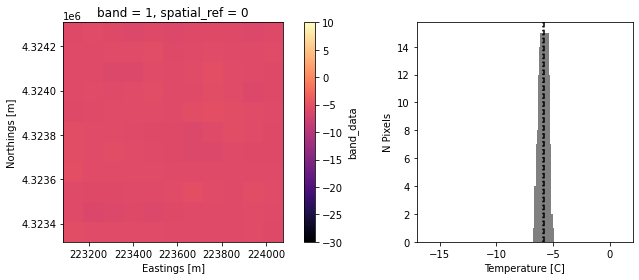

In [52]:
data = shapefile_tb_C.values

# remove nans from data
data = data[~np.isnan(data)]


fig, [ax_img, ax_hist] = plt.subplots(nrows=1,ncols=2,figsize=(10,4), tight_layout=True,
                                              gridspec_kw={'width_ratios': [2, 1]})
shapefile_tb_C.plot(cmap='magma', vmin=-30, vmax=10, ax=ax_img)
ax_img.set_aspect('equal', 'box')
ax_img.set_ylabel('Northings [m]')
ax_img.set_xlabel('Eastings [m]')




y_hist, _ = np.histogram(data, bins=100, density=False)
x_hist = np.linspace(np.min(data), np.max(data), num=len(y_hist))
ax_hist.bar(x_hist, y_hist, color='grey')
ax_hist.axvline(np.median(data),color='k',linestyle='--')
ax_hist.axvline(np.mean(data),color='k',linestyle=':')
ax_hist.set_xlim(-17, 2)
#ax_hist.set_ylim(0,1)
ax_hist.set_ylabel('N Pixels')
ax_hist.set_xlabel('Temperature [C]')

aster_mesa_west_mean_TC = np.mean(data)
aster_mesa_west_median_TC = np.median(data)
aster_mesa_west_std_TC = np.std(data)
aster_mesa_west_mean_TK = aster_mesa_west_mean_TC + 273.15
aster_mesa_west_median_TK = aster_mesa_west_median_TC + 273.15

print(aster_mesa_west_mean_TK)
print(aster_mesa_west_median_TK)
print(aster_mesa_west_std_TC)

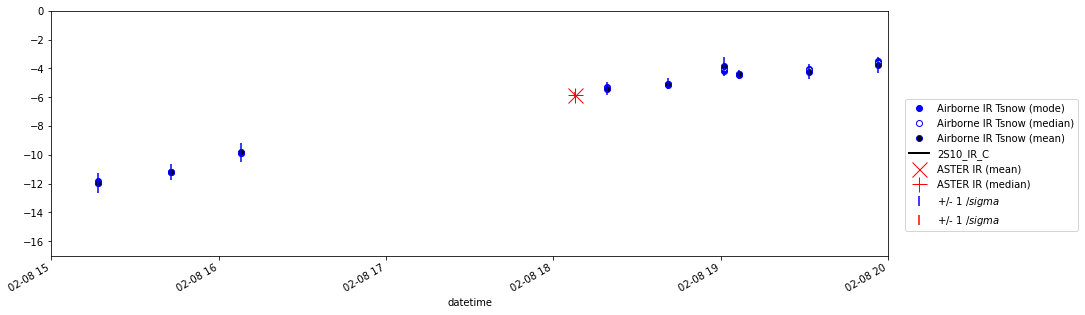

In [53]:
gm1 = df_merged

if target == 'mesa west':

    fig, ax =plt.subplots(1,1,figsize=(15,5))
    
    
    
    ax.plot(times,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
    ax.plot(times,Ttree_airborneIR_peak,'^g', label='Airborne IR Ttree (mode)')
    ax.plot(times,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
    ax.plot(times,Ttree_airborneIR_median,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
    ax.plot(times,Tsnow_airborneIR_mean,'ob', markerfacecolor='k', label='Airborne IR Tsnow (mean)')
    ax.plot(times,Ttree_airborneIR_mean,'^g', markerfacecolor='k', label='Airborne IR Ttree (mean)')
    
    ax.errorbar(x=times,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')
    ax.errorbar(x=times,y=Ttree_airborneIR_mean, yerr=Ttree_airborneIR_std, color='g', linestyle='none', label='+/- 1 $/sigma$')
    
    
    #gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=2, c='k', label='2S10_IR_C', zorder=99)
    
    df.AirTC_10ft_Avg_C.plot(ax=ax, label='AirTC_10ft_Avg_C',linestyle='--')
    df.AirTC_20ft_Avg_C.plot(ax=ax, label='AirTC_20ft_Avg_C',linestyle='--')
    df.IRtarget_nadir1_C_Avg.plot(ax=ax, label='IRtarget_nadir1_C_Avg')
    #df.IRtarget_nadir2_C_Avg.plot(ax=ax, label='IRtarget_nadir2_C_Avg')
    df.IRtarget_30degN_C_Avg.plot(ax=ax, label='IRtarget_30degN_C_Avg')
    #df.TsnowTrue.plot(ax=ax, c='tab:blue', label='West Met station Tsnow')
    #df.TtreeTrue.plot(ax=ax, c='tab:green', label='West Met station Tair')
    #df.TsnowEst.plot(marker='.',ax=ax)
    #df.TtreeEst.plot(marker='.',ax=ax)
    
    aster_time = np.datetime64('2020-02-08T18:07:48')
    ax.plot(aster_time,aster_mesa_west_mean_TC,'xr',markersize=15, markerfacecolor='r', label='ASTER IR (mean)')
    ax.plot(aster_time,aster_mesa_west_median_TC,'+r',markersize=15, markerfacecolor='r', label='ASTER IR (median)')

    
    
    ax.set_xlim(np.datetime64('2020-02-08T15'),np.datetime64('2020-02-08T20'))
    ax.set_ylim(-17,0)
    
    plt.legend(loc=(1.02,0.1))
    
    #ax2 = ax.twinx()
    #df.Solar.plot(ax=ax2)
    
if target == 'snow pit':
    
    fig, ax =plt.subplots(1,1,figsize=(15,5))
    
    
    
    ax.plot(times,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
    ax.plot(times,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
    ax.plot(times,Tsnow_airborneIR_mean,'ob', markerfacecolor='k', label='Airborne IR Tsnow (mean)')
    
    ax.errorbar(x=times,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')
    
    
    gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=2, c='k', label='2S10_IR_C', zorder=99)
    
    
    aster_time = np.datetime64('2020-02-08T18:07:48')
    ax.plot(aster_time,aster_mesa_west_mean_TC,'xr',markersize=15, markerfacecolor='r', label='ASTER IR (mean)')
    ax.plot(aster_time,aster_mesa_west_median_TC,'+r',markersize=15, markerfacecolor='r', label='ASTER IR (median)')
    ax.errorbar(x=aster_time,y=aster_mesa_west_mean_TC, yerr=aster_mesa_west_std_TC, color='r', linestyle='none', label='+/- 1 $/sigma$')

    
    ax.set_xlim(np.datetime64('2020-02-08T15'),np.datetime64('2020-02-08T20'))
    ax.set_ylim(-17,0)
    
    plt.legend(loc=(1.02,0.1))


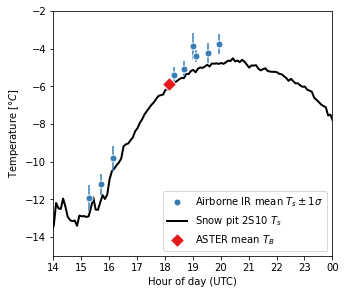

In [54]:
if target == 'mesa west':

    fig, ax =plt.subplots(1,1,figsize=(5,5))
    
    #ax.plot(times,Ttree_airborneIR_peak+273.15,'^g', label='Airborne IR Ttree (mode)')
    #ax.plot(times,Ttree_airborneIR_median+273.15,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
    ax.plot(times,Ttree_airborneIR_mean+273.15,'^g', markerfacecolor='k', label='Airborne IR Ttree (mean)')
    
    ax.errorbar(x=times,y=Ttree_airborneIR_mean+273.15, yerr=Ttree_airborneIR_std, color='g', linestyle='none', label='+/- 1 $/sigma$')
    
    #gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=2, c='k', label='2S10_IR_C', zorder=99)
    
    #df.AirTC_10ft_Avg_C.plot(ax=ax, label='AirTC_10ft_Avg_C',linestyle='--')
    (df_merged.AirTC_20ft_Avg).plot(ax=ax, label='AirTC_20ft_Avg_C',linestyle='--', color='k')
    #df.IRtarget_nadir1_C_Avg.plot(ax=ax, label='IRtarget_nadir1_C_Avg')
    #df.IRtarget_nadir2_C_Avg.plot(ax=ax, label='IRtarget_nadir2_C_Avg')
    #df.IRtarget_30degN_C_Avg.plot(ax=ax, label='IRtarget_30degN_C_Avg')
    #df.TsnowTrue.plot(ax=ax, c='tab:blue', label='West Met station Tsnow')
    #df.TtreeTrue.plot(ax=ax, c='tab:green', label='West Met station Tair')
    #df.TsnowEst.plot(marker='.',ax=ax)
    #df.TtreeEst.plot(marker='.',ax=ax)
    
    ax.set_xlim(np.datetime64('2020-02-08T13'),np.datetime64('2020-02-09T00'))
    ax.set_ylim(265,275)
    ax.set_ylabel('Temperature, K')
    ax.set_xlabel('Time')
    
    plt.legend(loc='lower right')
    
    #ax2 = ax.twinx()
    #df.Solar.plot(ax=ax2)
    
if target == 'snow pit':
    fig, ax =plt.subplots(1,1,figsize=(5,5))

    #ax.plot(times,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
    #ax.plot(times,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
    ax.plot(times,Tsnow_airborneIR_mean,'o', markeredgecolor='w', markerfacecolor='#377eb8', markersize=7, label='Airborne IR mean $T_s \pm 1 \sigma$', zorder=999)
    
    ax.errorbar(x=times,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='#377eb8', linestyle='none', label=None)
    
    #gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=2, c='k', label='2S10_IR_C', zorder=99)
    (df_merged.rad_avg-273.15).plot(ax=ax, linestyle='-', linewidth=2, c='k', label='Snow pit 2S10 $T_s$', zorder=-999)
    
    aster_time = pd.Timestamp('2020-02-08T18:07:48')
    ax.plot(aster_time,aster_mesa_west_mean_TC,'Dw',markersize=10, markerfacecolor='#e41a1c', label='ASTER mean $T_B$')
    #ax.plot(aster_time,aster_mesa_west_median_TK,'Dr',markersize=15, markerfacecolor='w', label='ASTER IR (median)')
    #ax.errorbar(x=aster_time,y=aster_mesa_west_mean_TK, yerr=aster_mesa_west_std_TC, color='r', linestyle='none', label='+/- 1 $/sigma$')

    
    
    ax.set_xlim(np.datetime64('2020-02-08T14'),np.datetime64('2020-02-09T00'))
    ax.set_ylim(-15,-2)
    ax.set_ylabel('Temperature [$\degree C$]')
    ax.set_xlabel('Hour of day (UTC)')
    
    # Text in the x-axis will be displayed in 'YYYY-mm' format.
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    # Rotates and right-aligns the x labels so they don't crowd each other.
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=0, horizontalalignment='center')
    
    
    plt.legend(loc='lower right')
    
plt.savefig('fig6a.svg')

Mean Difference between Airborne Tsnow and gm1_2s10_IR_45deg_C:
0.7669351453993222
Difference between ASTER T and gm1_2s10_IR_45deg_C:
0.2650088905334087


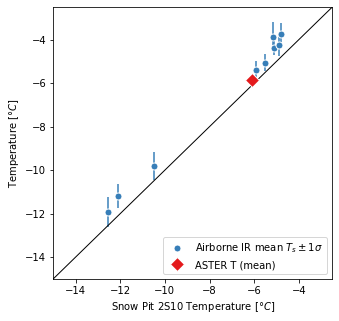

In [55]:
# Select a time window from the timeseries data around each airborne or satellite observation
df = df_merged
gm1 = df_merged
plus_minus_minutes = 10 # e.g. +/- 5 minutes for a 10 minute time window

mean_AirTC_10ft_Avg_C = []
mean_AirTC_20ft_Avg_C = []
mean_IRtarget_nadir1_C_Avg = []
mean_IRtarget_30degN_C_Avg = []
gm1_2s10_IR_45deg_C = []

for i, t in enumerate(times):
    window_start_time = pd.to_datetime(t) - datetime.timedelta(minutes=plus_minus_minutes)
    window_end_time = pd.to_datetime(t) + datetime.timedelta(minutes=plus_minus_minutes)
    df_sliced = df[(df.index>window_start_time) & (df.index<window_end_time)]
    gm1_sliced = gm1[(gm1.index>window_start_time) & (gm1.index<window_end_time)]

    #mean_AirTC_10ft_Avg_C.append(df_sliced.AirTC_10ft_Avg_C.mean())
    mean_AirTC_20ft_Avg_C.append(df_sliced.AirTC_20ft_Avg.mean())
    #mean_IRtarget_nadir1_C_Avg.append(df_sliced.IRtarget_nadir1_C_Avg.mean())
    #mean_IRtarget_30degN_C_Avg.append(df_sliced.IRtarget_30degN_C_Avg.mean())
    gm1_2s10_IR_45deg_C.append(gm1_sliced.rad_avg.mean())
    
if target == 'mesa west':    
    #fig, ax = plt.subplots(figsize=(4,4))
    #
    ##ax.plot(mean_IRtarget_nadir1_C_Avg,Tsnow_airborneIR_peak+273.15,'ob', label='Airborne IR Tsnow (mode)')
    #ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_peak+273.15,'^g', label='Airborne IR Ttree (mode)')
    ##ax.plot(mean_IRtarget_nadir1_C_Avg,Tsnow_airborneIR_median+273.15,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
    #ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_median+273.15,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
    ##ax.plot(mean_IRtarget_nadir1_C_Avg,Tsnow_airborneIR_mean+273.15,'ob', markerfacecolor='k', label='Airborne IR Tsnow (mean)')
    #ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_mean+273.15,'^g', markerfacecolor='k', label='Airborne IR Ttree (mean)')
    #    
    #    
    ##ax.errorbar(x=mean_IRtarget_nadir1_C_Avg,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')
    #ax.errorbar(x=mean_AirTC_20ft_Avg_C,y=Ttree_airborneIR_mean, yerr=Ttree_airborneIR_std, color='g', linestyle='none', label='+/- 1 $/sigma$')
    #
    #
    #ax.plot([-20,20],[-20,20],linestyle='-', linewidth=1,color='k')
    #
    ##ax.axhline(aster_mesa_west_mean_TC,linestyle='-',color='r',label='ASTER IR (mean)')
    ##ax.axhline(aster_mesa_west_median_TC,linestyle='--',color='r',label='ASTER IR (median)')
    #
    #ax.legend()
    #
    #ax.set_ylim((-17,2))
    #ax.set_xlim((-17,2))
    #
    #ax.set_xlabel('In Situ Temperatures, $\degree C$\n(IRtarget_nadir1_C_Avg & AirTC_10ft_Avg_C)')
    #ax.set_ylabel('Airborne IR Temperatures, $\degree C$')
    #
    #
    ##print('Mean Difference between Airborne Tsnow and IRtarget_nadir1_C_Avg:')
    ##print(np.mean(Tsnow_airborneIR_mean - mean_IRtarget_nadir1_C_Avg))
    #print('Mean Difference between Airborne Tveg and mean_AirTC_20ft_Avg_C:')
    #print(np.mean(Ttree_airborneIR_median - mean_AirTC_20ft_Avg_C))
    
    ##########

    fig, ax = plt.subplots(figsize=(5,5))
    
    #ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_peak+273.15,'^g', label='Airborne IR Ttree (mode)')
    #ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_median+273.15,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
    ax.plot(mean_AirTC_20ft_Avg_C,Ttree_airborneIR_mean+273.15,'og', markerfacecolor='w', label='Airborne IR Ttree (mean)', zorder=999)
        
        
    #ax.errorbar(x=mean_IRtarget_30degN_C_Avg,y=Tsnow_airborneIR_mean+273.15, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')
    ax.errorbar(x=mean_AirTC_20ft_Avg_C,y=Ttree_airborneIR_mean+273.15, yerr=Ttree_airborneIR_std, color='g', linestyle='none', label='+/- 1 $/sigma$')
    
    ax_min, ax_max = 265, 275
    ax.plot([ax_min, ax_max],[ax_min, ax_max],linestyle='-', linewidth=1,color='k')
    
    #ax.axhline(aster_mesa_west_mean_TC,linestyle='-',color='r',label='ASTER IR (mean)')
    #ax.axhline(aster_mesa_west_median_TC,linestyle='--',color='r',label='ASTER IR (median)')
    
    ax.legend()
    
    ax.set_ylim((ax_min, ax_max))
    ax.set_xlim((ax_min, ax_max))
    
    ax.set_xlabel('In Situ Temperatures, $\degree C$\n(IRtarget_30degN_C_Avg & AirTC_20ft_Avg_C)')
    ax.set_ylabel('Airborne IR Temperatures, $\degree C$')
    
    #print('Mean Difference between Airborne Tsnow and IRtarget_30degN_C_Avg:')
    #print(np.mean(Tsnow_airborneIR_mean - mean_IRtarget_30degN_C_Avg))
    print('Mean Difference between Airborne Tveg and mean_AirTC_20ft_Avg_C:')
    print(np.mean(Ttree_airborneIR_median+273.15 - mean_AirTC_20ft_Avg_C))
    
    #########

    
if target == 'snow pit':
    fig, ax = plt.subplots(figsize=(5,5))
    
    #ax.plot(gm1_2s10_IR_45deg_C,Tsnow_airborneIR_peak+273.15,'ob', label='Airborne IR Tsnow (mode)')
    #ax.plot(gm1_2s10_IR_45deg_C,Tsnow_airborneIR_median+273.15,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
    ax.plot((np.array(gm1_2s10_IR_45deg_C)-273.15),Tsnow_airborneIR_mean,'o', markerfacecolor='#377eb8', markeredgecolor='w', markersize=7, label='Airborne IR mean $T_s \pm 1 \sigma$', zorder=999)
        
        
    ax.errorbar(x=(np.array(gm1_2s10_IR_45deg_C)-273.15),y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='#377eb8', linestyle='none', label=None)
    
    ax_min, ax_max = -15, -2.5
    ax.plot([ax_min, ax_max],[ax_min, ax_max],linestyle='-', linewidth=1,color='k')
    
    #ax.axhline(aster_mesa_west_mean_TC,linestyle='-',color='r',label='ASTER IR (mean)')
    #ax.axhline(aster_mesa_west_median_TC,linestyle='--',color='r',label='ASTER IR (median)')
    aster_window_start_time = pd.to_datetime(aster_time) - datetime.timedelta(minutes=plus_minus_minutes)
    aster_window_end_time = pd.to_datetime(aster_time) + datetime.timedelta(minutes=plus_minus_minutes)
    gm1_aster_time = gm1[(gm1.index>aster_window_start_time) & (gm1.index<aster_window_end_time)]
    ax.plot(gm1_aster_time.rad_avg.mean()-273.15,aster_mesa_west_mean_TK-273.15,'Dw',markersize=10, markerfacecolor='#e41a1c', label='ASTER T (mean)', zorder=999)
    #ax.errorbar(x=gm1_aster_time.rad_avg.mean()-273.15,y=aster_mesa_west_mean_TK-273.15, yerr=aster_mesa_west_std_TC, color='r', linestyle='none', label='+/- 1 $/sigma$')

    
    
    ax.legend(loc='lower right')
    
    ax.set_ylim((ax_min, ax_max))
    ax.set_xlim((ax_min, ax_max))
    
    ax.set_xlabel('Snow Pit 2S10 Temperature [$\degree C$]')
    ax.set_ylabel('Temperature [$\degree C$]')
    
    
    print('Mean Difference between Airborne Tsnow and gm1_2s10_IR_45deg_C:')
    print(np.mean(Tsnow_airborneIR_mean+273.15 - gm1_2s10_IR_45deg_C))
    
    print('Difference between ASTER T and gm1_2s10_IR_45deg_C:')
    print(np.mean(aster_mesa_west_mean_TK - gm1_aster_time.rad_avg.mean()))
    
plt.savefig('fig6b.svg')

---

Airborne IR versus in situ IR Tsnow, as a function of the in situ view angles.

(airborne IR median - in situ measurement)


In [56]:
#x = np.array([(Tsnow_airborneIR_median - mean_IRtarget_nadir1_C_Avg),
#    (Tsnow_airborneIR_median - mean_IRtarget_30degN_C_Avg),
#    (Tsnow_airborneIR_median - gm1_2s10_IR_45deg_C)])

ValueError: operands could not be broadcast together with shapes (9,) (0,) 

In [57]:
plt.plot(times,x.T,'o-');

plt.legend(['Mesa West, 0deg','Mesa West, 30deg','SnowPit 2S10, 45deg'])
plt.ylabel('Airborne IR - In Situ\nsnow temperature difference (degC)')
plt.axhline(0,linestyle='--', color='k', zorder=-999)


AttributeError: 'int' object has no attribute 'T'

TypeError: 'int' object is not subscriptable

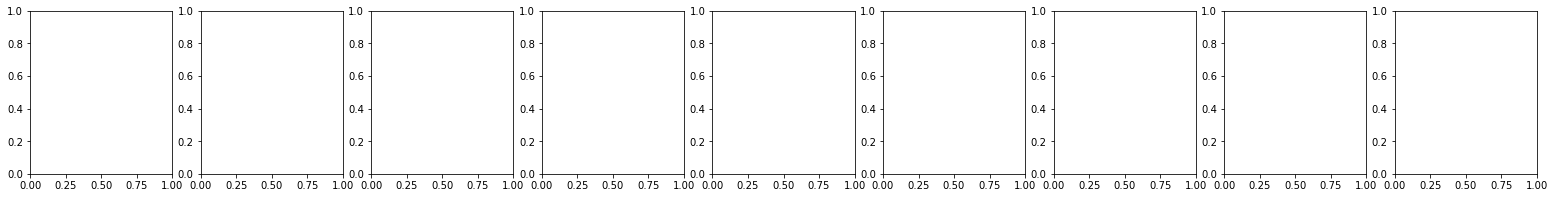

In [58]:


fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(27,3))

for n in range(9):
    axs[n].plot([0,30,45],x[:,n],'-o');
    axs[n].axhline(x[0,n]-x[1,n],linestyle='-',color='r')
    axs[n].axhline(0,linestyle='--', color='k', zorder=-999)
    axs[0].set_ylabel('Airborne IR - In Situ\nsnow temperature difference (degC)')
    axs[n].set_xlabel('in situ radiometer angle')
    axs[n].set_ylim(-2,5)

# ---
---

# ASTER

In [59]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
import xarray as xr
from shapely.geometry import box, mapping
import aster_utils

def tir_dn2rad(DN, band):
    '''Convert AST_L1T Digital Number values to At-Sensor Radiance for the TIR bands (bands 10-14).'''
    ucc = [6.822e-3, 6.780e-3, 6.590e-3, 5.693e-3, 5.225e-3]
    rad = (DN-1.) * ucc[band-10]
    return rad

def tir_rad2tb(rad, band):
    '''Convert AST_L1T At-Sensor Radiance to Brightness Temperature [K] for the TIR bands (bands 10-14).'''
    k1 = [3047.47, 2480.93, 1930.80, 865.65, 649.60]
    k2 = [1736.18, 1666.21, 1584.72,1349.82, 1274.49]
    tb = k2[band-10] /  np.log((k1[band-10]/rad) + 1)
    return tb

In [60]:
aster_l1t_filepath = r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\ASTER\ASTER_L1T_2020_GrandMesa_SnowEx\output\AST_L1T_00302082020180748_20200209065849_17218_ImageData14.tif"
dst_crs = 'EPSG:4326'

new_filepath = aster_utils.reproject_aster_l1t(aster_l1t_filepath, dst_crs = 'EPSG:32613')
print(new_filepath)

C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\ASTER\ASTER_L1T_2020_GrandMesa_SnowEx\output\AST_L1T_00302082020180748_20200209065849_17218_ImageData14_EPSG_32613.tif


In [61]:
# Open ASTER image
aster_b14_DN = xr.open_dataset(new_filepath, engine="rasterio")
aster_b14_DN.rio.write_crs("epsg:32613", inplace=True)
aster_b14_DN = aster_b14_DN.squeeze()

#Convert DN to radiance, then radiance to brightness temperature
# ASTER band number for conversion functions
band_number = 14

# Convert DN to Radiance
aster_b14_rad = tir_dn2rad(aster_b14_DN, band_number)

# Convert Radiance to Brightness Temperature [K]
aster_b14_tb = tir_rad2tb(aster_b14_rad, band_number)

# Open shapefiles
g16_shapefile = gpd.read_file(r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\Mountain GOES Paper\Paper 2 - satellite vs ground\Paper 2a - snowex data\data\pixels_GOES-16_ABI.geojson")
g17_shapefile = gpd.read_file(r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\Mountain GOES Paper\Paper 2 - satellite vs ground\Paper 2a - snowex data\data\pixels_GOES-17_ABI.geojson")

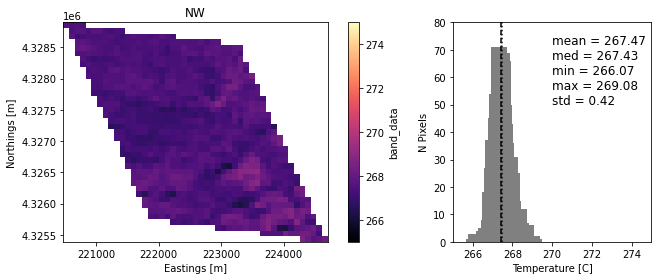

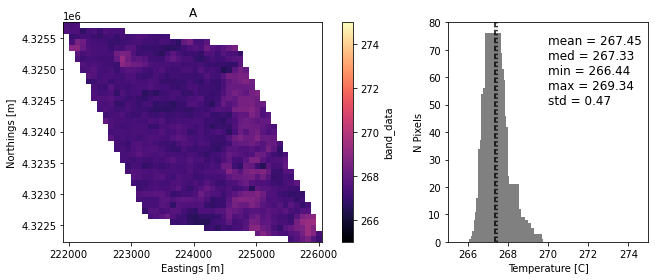

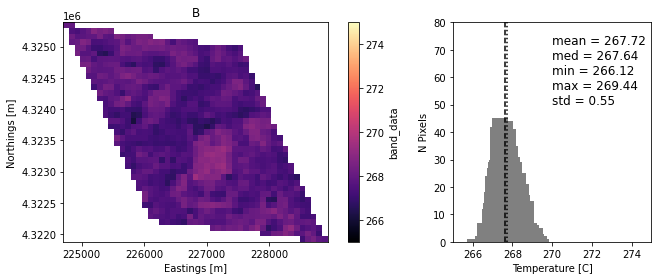

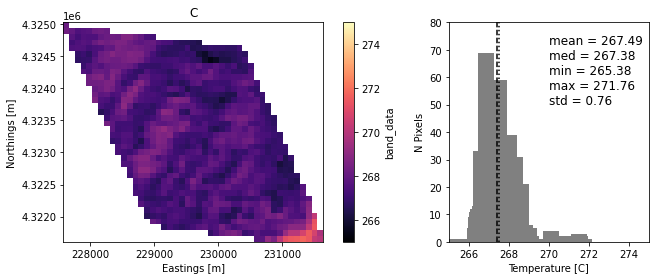

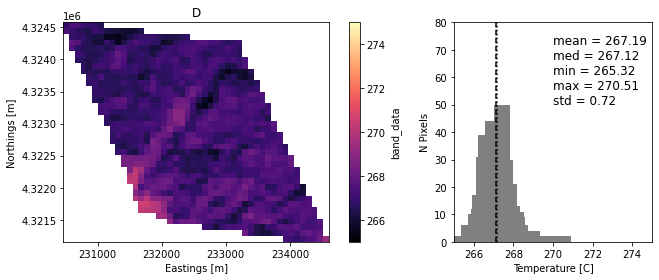

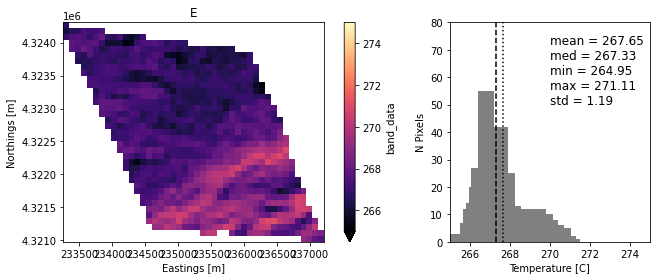

In [62]:
for i in range(len(g16_shapefile.to_crs('epsg:32613').geometry)):
    cropping_geometries = [g16_shapefile.to_crs('epsg:32613').geometry[i]]
    #geometry = f'''{{"type": "Polygon", "coordinates": [[[{utm_xmin}, {utm_ymax}],[{utm_xmin}, {utm_ymin}],[{utm_xmax}, {utm_ymin}],[{utm_xmax}, {utm_ymax}],[{utm_xmin}, {utm_ymax}]]]}}'''
    #cropping_geometries = [geojson.loads(geometry)]
    shapefile_tb = aster_b14_tb.rio.clip(geometries=cropping_geometries, crs=32613)
    shapefile_tb_K = shapefile_tb.band_data
    shapefile_tb_C = shapefile_tb.band_data - 273.15
    #plt.figure()
    #shapefile_tb_C.plot(cmap='magma')
    
    data = shapefile_tb_K.values

    # remove nans from data
    data = data[~np.isnan(data)]
    
    
    fig, [ax_img, ax_hist] = plt.subplots(nrows=1,ncols=2,figsize=(10,4), tight_layout=True,
                                                  gridspec_kw={'width_ratios': [2, 1]})
    shapefile_tb_K.plot(cmap='magma', vmin=265, vmax=275, ax=ax_img)
    ax_img.set_aspect('equal', 'box')
    ax_img.set_ylabel('Northings [m]')
    ax_img.set_xlabel('Eastings [m]')
    ax_img.set_title(g16_shapefile.name[i])
    
    
    
    
    y_hist, _ = np.histogram(data, bins=100, density=False)
    x_hist = np.linspace(np.min(data), np.max(data), num=len(y_hist))
    ax_hist.bar(x_hist, y_hist, color='grey')
    ax_hist.axvline(np.median(data),color='k',linestyle='--')
    ax_hist.axvline(np.mean(data),color='k',linestyle=':')
    ax_hist.set_xlim(265, 275)
    ax_hist.set_ylim(0,80)
    ax_hist.set_ylabel('N Pixels')
    ax_hist.set_xlabel('Temperature [C]')
    s1 = str(np.round(np.mean(data),2))
    s2 = str(np.round(np.median(data),2))
    s3 = str(np.round(np.min(data),2))
    s4 = str(np.round(np.max(data),2))
    s5 = str(np.round(np.std(data),2))
    ax_hist.text(270, 50, f'mean = {s1}\nmed = {s2}\nmin = {s3}\nmax = {s4}\nstd = {s5}', fontsize=12)
    
    aster_mesa_west_mean_TC = np.mean(data)
    aster_mesa_west_median_TC = np.median(data)

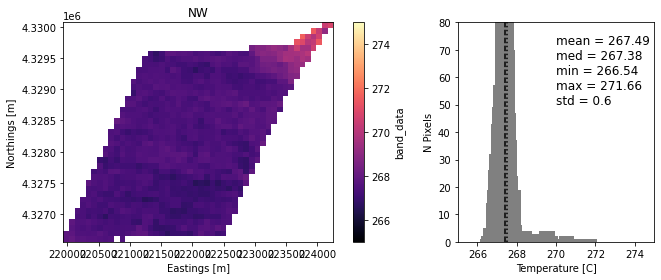

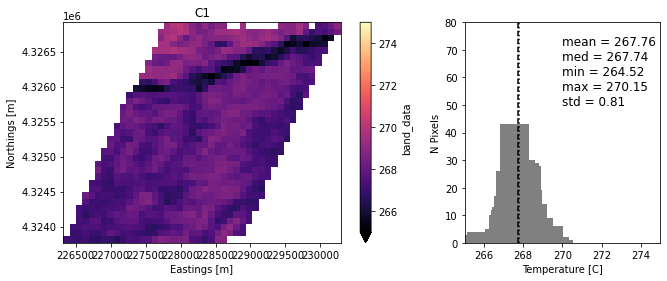

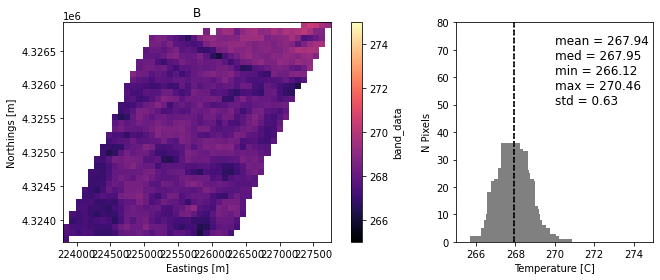

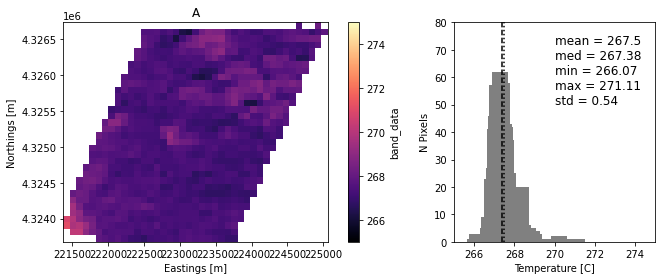

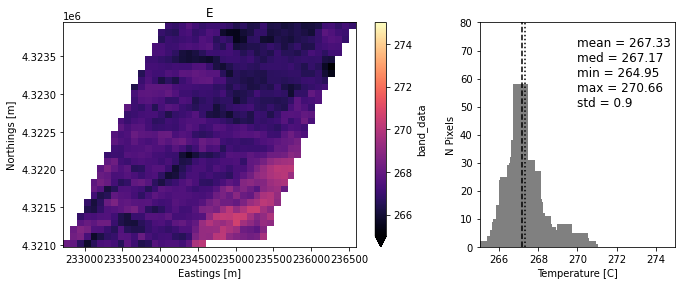

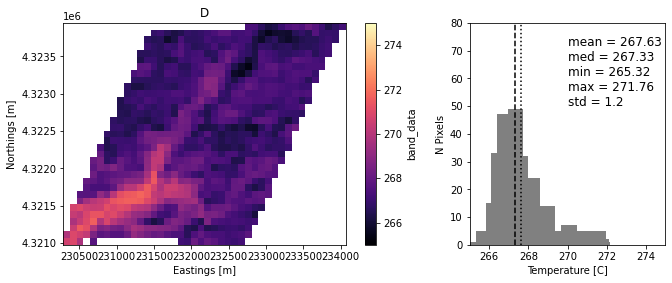

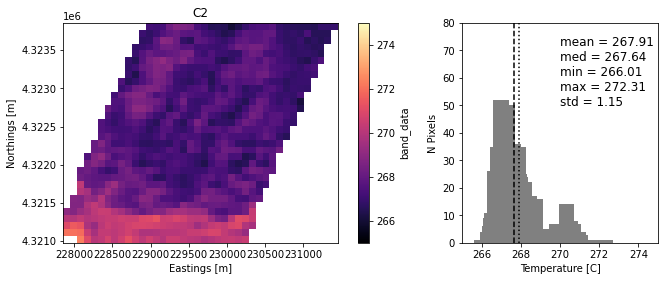

In [63]:
for i in range(len(g17_shapefile.to_crs('epsg:32613').geometry)):
    cropping_geometries = [g17_shapefile.to_crs('epsg:32613').geometry[i]]
    #geometry = f'''{{"type": "Polygon", "coordinates": [[[{utm_xmin}, {utm_ymax}],[{utm_xmin}, {utm_ymin}],[{utm_xmax}, {utm_ymin}],[{utm_xmax}, {utm_ymax}],[{utm_xmin}, {utm_ymax}]]]}}'''
    #cropping_geometries = [geojson.loads(geometry)]
    shapefile_tb = aster_b14_tb.rio.clip(geometries=cropping_geometries, crs=32613)
    shapefile_tb_K = shapefile_tb.band_data
    shapefile_tb_C = shapefile_tb.band_data - 273.15
    #plt.figure()
    #shapefile_tb_C.plot(cmap='magma')
    
    data = shapefile_tb_K.values

    # remove nans from data
    data = data[~np.isnan(data)]
    
    
    fig, [ax_img, ax_hist] = plt.subplots(nrows=1,ncols=2,figsize=(10,4), tight_layout=True,
                                                  gridspec_kw={'width_ratios': [2, 1]})
    shapefile_tb_K.plot(cmap='magma', vmin=265, vmax=275, ax=ax_img)
    ax_img.set_aspect('equal', 'box')
    ax_img.set_ylabel('Northings [m]')
    ax_img.set_xlabel('Eastings [m]')
    ax_img.set_title(g17_shapefile.name[i])
    
    
    
    
    y_hist, _ = np.histogram(data, bins=100, density=False)
    x_hist = np.linspace(np.min(data), np.max(data), num=len(y_hist))
    ax_hist.bar(x_hist, y_hist, color='grey')
    ax_hist.axvline(np.median(data),color='k',linestyle='--')
    ax_hist.axvline(np.mean(data),color='k',linestyle=':')
    ax_hist.set_xlim(265, 275)
    ax_hist.set_ylim(0,80)
    ax_hist.set_ylabel('N Pixels')
    ax_hist.set_xlabel('Temperature [C]')
    s1 = str(np.round(np.mean(data),2))
    s2 = str(np.round(np.median(data),2))
    s3 = str(np.round(np.min(data),2))
    s4 = str(np.round(np.max(data),2))
    s5 = str(np.round(np.std(data),2))
    ax_hist.text(270, 50, f'mean = {s1}\nmed = {s2}\nmin = {s3}\nmax = {s4}\nstd = {s5}', fontsize=12)
    
    aster_mesa_west_mean_TC = np.mean(data)
    aster_mesa_west_median_TC = np.median(data)

---

### Add ASTER to plot

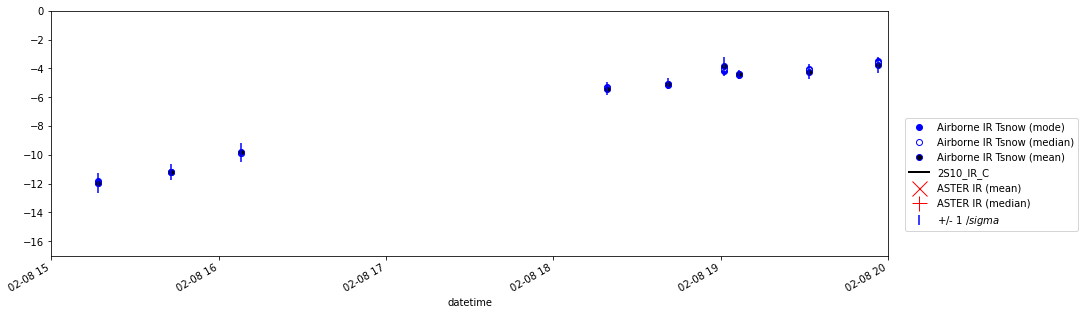

In [64]:
if target == 'mesa west':

    fig, ax =plt.subplots(1,1,figsize=(15,5))
    
    
    
    ax.plot(times,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
    ax.plot(times,Ttree_airborneIR_peak,'^g', label='Airborne IR Ttree (mode)')
    ax.plot(times,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
    ax.plot(times,Ttree_airborneIR_median,'^g', markerfacecolor='w', label='Airborne IR Ttree (median)')
    ax.plot(times,Tsnow_airborneIR_mean,'ob', markerfacecolor='k', label='Airborne IR Tsnow (mean)')
    ax.plot(times,Ttree_airborneIR_mean,'^g', markerfacecolor='k', label='Airborne IR Ttree (mean)')
    
    ax.errorbar(x=times,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')
    ax.errorbar(x=times,y=Ttree_airborneIR_mean, yerr=Ttree_airborneIR_std, color='g', linestyle='none', label='+/- 1 $/sigma$')
    
    
    #gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=2, c='k', label='2S10_IR_C', zorder=99)
    
    df.AirTC_10ft_Avg_C.plot(ax=ax, label='AirTC_10ft_Avg_C',linestyle='--')
    df.AirTC_20ft_Avg_C.plot(ax=ax, label='AirTC_20ft_Avg_C',linestyle='--')
    df.IRtarget_nadir1_C_Avg.plot(ax=ax, label='IRtarget_nadir1_C_Avg')
    #df.IRtarget_nadir2_C_Avg.plot(ax=ax, label='IRtarget_nadir2_C_Avg')
    df.IRtarget_30degN_C_Avg.plot(ax=ax, label='IRtarget_30degN_C_Avg')
    #df.TsnowTrue.plot(ax=ax, c='tab:blue', label='West Met station Tsnow')
    #df.TtreeTrue.plot(ax=ax, c='tab:green', label='West Met station Tair')
    #df.TsnowEst.plot(marker='.',ax=ax)
    #df.TtreeEst.plot(marker='.',ax=ax)
    
    aster_time = np.datetime64('2020-02-08T18:07:48')
    ax.plot(aster_time,aster_mesa_west_mean_TC,'xr',markersize=15, markerfacecolor='r', label='ASTER IR (mean)')
    ax.plot(aster_time,aster_mesa_west_median_TC,'+r',markersize=15, markerfacecolor='r', label='ASTER IR (median)')
    
    
    ax.set_xlim(np.datetime64('2020-02-08T15'),np.datetime64('2020-02-08T20'))
    ax.set_ylim(-17,0)
    
    plt.legend(loc=(1.02,0.1))
    
    #ax2 = ax.twinx()
    #df.Solar.plot(ax=ax2)
    
if target == 'snow pit':
    
    fig, ax =plt.subplots(1,1,figsize=(15,5))
    
    
    
    ax.plot(times,Tsnow_airborneIR_peak,'ob', label='Airborne IR Tsnow (mode)')
    ax.plot(times,Tsnow_airborneIR_median,'ob', markerfacecolor='w', label='Airborne IR Tsnow (median)')
    ax.plot(times,Tsnow_airborneIR_mean,'ob', markerfacecolor='k', label='Airborne IR Tsnow (mean)')
    
    ax.errorbar(x=times,y=Tsnow_airborneIR_mean, yerr=Tsnow_airborneIR_std, color='b', linestyle='none', label='+/- 1 $/sigma$')
    
    
    gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=2, c='k', label='2S10_IR_C', zorder=99)
    
    
    aster_time = np.datetime64('2020-02-08T18:07:48')
    ax.plot(aster_time,aster_mesa_west_mean_TC,'xr',markersize=15, markerfacecolor='r', label='ASTER IR (mean)')
    ax.plot(aster_time,aster_mesa_west_median_TC,'+r',markersize=15, markerfacecolor='r', label='ASTER IR (median)')
    
    
    ax.set_xlim(np.datetime64('2020-02-08T15'),np.datetime64('2020-02-08T20'))
    ax.set_ylim(-17,0)
    
    plt.legend(loc=(1.02,0.1))
